# System Model V3 - Shock test

The purpose of this notebook is to perform shocks of ETH price to test controller parameter stability, without stochastic processes.

For this simulation run, we will be asking the following question: how does the model behave with a eth price shock?

Run simulation with overrides over the default values:
* 'controller_enabled': [True],
* 'liquidation_ratio': [1.45],
* 'interest_rate': [1.03],
* 'liquidity_demand_enabled': [False],
* 'arbitrageur_considers_liquidation_ratio': [True],
* 'liquidity_demand_shock': [False],
*'eth_price': [lambda run, timestep, df=None: [
        # Shocks at 14 days; controller turns on at 7 days
        300,
        300 if timestep < 24 * 14 else 300 * 1.3, # 30% step, remains for rest of simulation
        300 * 1.3 if timestep in list(range(24*14, 24*14 + 6, 1)) else 300, # 30% impulse for 6 hours
        300 if timestep < 24 * 14 else 300 * 0.7, # negative 30% step, remains for rest of simulation
        300 * 0.7 if timestep in list(range(24*14, 24*14 + 6, 1)) else 300, # negative 30% impulse for 6 hours
    ][run - 1]],
* 'liquidity_demand_events': [lambda run, timestep, df=None: 0],
* 'token_swap_events': [lambda run, timestep, df=None: 0],
}

In order to test this, configure the following experiment [experiment_shocks.py](experiments/system_model_v3/experiment_shocks.py). Run run this simulation, we create a directory in the ```experiments/system_model_v3``` called ```experiment_shocks/```,and add a ```logs/``` directory inside of it.

Assuming our we have all of the requirements required (run requirements.txt from the ```reflexer/``` root directory to be sure. Assuming our terminal is in the root directory, we run the follow to run the simulation:

```bash
python3 -m experiments.system_model_v3.experiment_shocks
```
And our simulation will run. The resulting [run log](experiments/system_model_v3/experiment_shocks/experiment_run_log.md) can be found in the ```experiments/system_model_v3/experiment_shocks/``` directory, along with the simulation results stored as ```experiment_results.hdf5```

Note: The shocks experiment might display errors as the simulations fail under various shock conditions.

Below we will import and examine the simulation results.


In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

%matplotlib inline

## Import simulation run data


In [ ]:
os.getcwd()

In [ ]:
os.chdir('../../')
os.getcwd()

In [4]:
experiment_results = 'experiments/system_model_v3/experiment_shocks/experiment_results.hdf5'
experiment_results_keys = []
with pd.HDFStore(experiment_results) as store:
    experiment_results_keys = list(filter(lambda x: "results" in x, store.keys()))
    exceptions_keys = list(filter(lambda x: "exceptions" in x, store.keys()))

In [5]:
# A list of all experiment result keys
experiment_results_keys

['/results_2021-09-20T16:38:15.521748']

In [6]:
# Copy a results_ key from the above keys to select the experiment
experiment_results_key = experiment_results_keys[-1]
experiment_timestamp = experiment_results_key.strip('results_')
exceptions_key = 'exceptions_' + experiment_timestamp
experiment_timestamp

'/results_2021-09-20T16:38:15.521748'

In [7]:
df_raw = pd.read_hdf(experiment_results, experiment_results_key)
df_raw.tail()

,cdp_metrics,optimal_values,sim_metrics,timedelta,cumulative_time,timestamp,blockheight,eth_price,liquidity_demand,liquidity_demand_mean,...,rai_borrower_state,rai_borrower_max_balance,rai_lender_state,rai_lender_max_balance,simulation,subset,run,substep,timestep,events
100367,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,3873600,2018-02-14 20:00:00,0,300.0,0,0.0,...,0,0.0,0,0.0,0,23,5,18,1076,NaN
100368,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,3877200,2018-02-14 21:00:00,0,300.0,0,0.0,...,0,0.0,0,0.0,0,23,5,18,1077,NaN
100369,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,3880800,2018-02-14 22:00:00,0,300.0,0,0.0,...,0,0.0,0,0.0,0,23,5,18,1078,NaN
100370,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,3884400,2018-02-14 23:00:00,0,300.0,0,0.0,...,0,0.0,0,0.0,0,23,5,18,1079,NaN
100371,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,3888000,2018-02-15 00:00:00,0,300.0,0,0.0,...,0,0.0,0,0.0,0,23,5,18,1080,NaN


## Post process


In [8]:
from experiments.system_model_v3.post_process import post_process_results
from experiments.system_model_v3.experiment_shocks import params, SIMULATION_TIMESTEPS

/Users/georgekellerman/github/geb-sims/venv/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(



    * Number of timesteps: 1080 / 45.0 days
    * Number of MC runs: 5
    * Timestep duration: 0.004 seconds
    * Control parameters: ['kp', 'ki']
    * Number of parameter combinations: 24
    * Expected experiment duration: 8.639999999999999 minutes / 0.144 hours
    


In [44]:
#params

In [10]:
# add swept parameters as a column
df = post_process_results(df_raw, params, set_params=['kp', 'ki', 'liquidation_ratio'])
df

,cdp_metrics,optimal_values,sim_metrics,timedelta,cumulative_time,timestamp,blockheight,eth_price,liquidity_demand,liquidity_demand_mean,...,eth_leverager_debt_base,eth_leverager_collateral,eth_leverager_debt,eth_leverager_cratio,eth_leverager_collateral_diff,kp,ki,liquidation_ratio,kp_rate,ki_rate
0,{},{},{},0,0,2018-01-01 00:00:00,0,294.069151,1,1.0000,...,0.0,0.0,0.0,NaN,NaN,5.000000e-07,-1.000000e-07,1.45,0.000000e+00,-0.000000e+00
1,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,3600,2018-01-01 01:00:00,0,300.000000,0,0.5000,...,0.0,0.0,0.0,NaN,0.0,5.000000e-07,-1.000000e-07,1.45,0.000000e+00,-0.000000e+00
2,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,7200,2018-01-01 02:00:00,0,300.000000,0,0.2500,...,0.0,0.0,0.0,NaN,0.0,5.000000e-07,-1.000000e-07,1.45,0.000000e+00,-0.000000e+00
3,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,10800,2018-01-01 03:00:00,0,300.000000,0,0.1250,...,0.0,0.0,0.0,NaN,0.0,5.000000e-07,-1.000000e-07,1.45,0.000000e+00,-0.000000e+00
4,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,14400,2018-01-01 04:00:00,0,300.000000,0,0.0625,...,0.0,0.0,0.0,NaN,0.0,5.000000e-07,-1.000000e-07,1.45,0.000000e+00,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100367,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,3873600,2018-02-14 20:00:00,0,300.000000,0,0.0000,...,0.0,0.0,0.0,NaN,0.0,1.000000e-08,1.000000e-08,1.45,-9.020562e-23,-3.247402e-19
100368,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,3877200,2018-02-14 21:00:00,0,300.000000,0,0.0000,...,0.0,0.0,0.0,NaN,0.0,1.000000e-08,1.000000e-08,1.45,-9.020562e-23,-3.247402e-19
100369,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,3880800,2018-02-14 22:00:00,0,300.000000,0,0.0000,...,0.0,0.0,0.0,NaN,0.0,1.000000e-08,1.000000e-08,1.45,-9.020562e-23,-3.247402e-19
100370,"{'cdp_count': 102, 'open_cdp_count': 102, 'clo...",{},{},3600,3884400,2018-02-14 23:00:00,0,300.000000,0,0.0000,...,0.0,0.0,0.0,NaN,0.0,1.000000e-08,1.000000e-08,1.45,-9.020562e-23,-3.247402e-19


# Simulation Analysis

In [11]:
df_raw.shape

(100372, 96)

In [12]:
df.substep.unique()

array([ 0, 18])

In [13]:
df.subset.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [14]:
df.run.unique()

array([1, 2, 3, 4, 5])

In [15]:
df.columns

Index(['cdp_metrics', 'optimal_values', 'sim_metrics', 'timedelta',
       'cumulative_time', 'timestamp', 'blockheight', 'eth_price',
       'liquidity_demand', 'liquidity_demand_mean', 'cdps', 'eth_collateral',
       'eth_locked', 'eth_freed', 'eth_bitten', 'liquidity_cdp_eth_collateral',
       'liquidity_cdp_rai_balance', 'liquidity_cdp_count',
       'arbitrage_cdp_eth_collateral', 'principal_debt', 'rai_drawn',
       'rai_wiped', 'rai_bitten', 'accrued_interest', 'interest_dripped',
       'interest_wiped', 'interest_bitten', 'w_1', 'w_2', 'w_3',
       'system_revenue', 'stability_fee', 'market_price', 'market_price_twap',
       'target_price', 'target_rate', 'eth_return', 'eth_gross_return',
       'expected_market_price', 'expected_debt_price',
       'price_trader_rai_balance', 'price_trader_base_balance',
       'price_traders', 'rate_trader_rai_balance', 'rate_trader_base_balance',
       'rate_traders', 'error_star', 'prev_error_star', 'error_star_integral',
       'mar

In [35]:
def plot_fan_chart(df,aggregate_dimension,x, y,lx=False,ly=False,density_hack=True):
    def q10(x):
        return x.quantile(0.1)

    def q20(x):
        return x.quantile(0.2)

    def q30(x):
        return x.quantile(0.3)

    def q40(x):
        return x.quantile(0.4)

    def q60(x):
        return x.quantile(0.6)

    def q70(x):
        return x.quantile(0.7)

    def q80(x):
        return x.quantile(0.8)

    def q90(x):
        return x.quantile(0.9)

    run_count = max(df.run)

    agg_metrics = [q10, q20, q30, q40, 'median', q60, q70, q80, q90]
    agg_df = df.groupby(aggregate_dimension).agg({y: agg_metrics})
    agg_metrics = agg_df.columns.levels[1].values
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    plt.figure(figsize=(15,9))

    df = agg_df.reset_index()
    lines = plt.plot(df[x], df[f'{y}_median'])
    color = lines[0].get_color()
    if density_hack:
        avg_iqr = []
        for i in range(len(agg_metrics)-1):
            m = (agg_metrics[i], agg_metrics[i+1])
            iqr = df[f'{y}_{m[1]}'] - df[f'{y}_{m[0]}']
            avg_iqr.append(iqr.sum())
        inv_avg_iqr = [1/i for i in avg_iqr]
        norm_avg_iqr = [i/max(inv_avg_iqr) for i in inv_avg_iqr]
        i = 0
        while i<len(agg_metrics)-1:
            m = (agg_metrics[i], agg_metrics[i+1])
            plt.fill_between(df[x], df[f'{y}_{m[0]}'], df[f'{y}_{m[1]}'], alpha=0.8*norm_avg_iqr[i], facecolor=color, edgecolor=None)
            i += 1
    else:
        i = 0
        while i<len(agg_metrics)/2:
            m = (agg_metrics[i], agg_metrics[-1-i])
            plt.fill_between(df[x], df[f'{y}_{m[0]}'], df[f'{y}_{m[1]}'], alpha=0.3, color=color)
            i += 1

    plt.xlabel(x)
    plt.ylabel(y)
    title_text = 'Distribution of ' + y + ' over all of ' + str(run_count) + ' Monte Carlo runs'
    plt.title(title_text)
    plt.legend(['Median', 'Interquantile Ranges'])
    if lx:
        plt.xscale('log')
    if ly:
        plt.yscale('log')

In [36]:
# calculate errors
df['error'] = df['target_price'] - df['market_price']
df['error_integral'] = df['error'].cumsum()

### Generate key plots for analysis

Text(0.5, 1.0, 'ETH price shocks (positive and negative step and impulse; one shock type for each run')

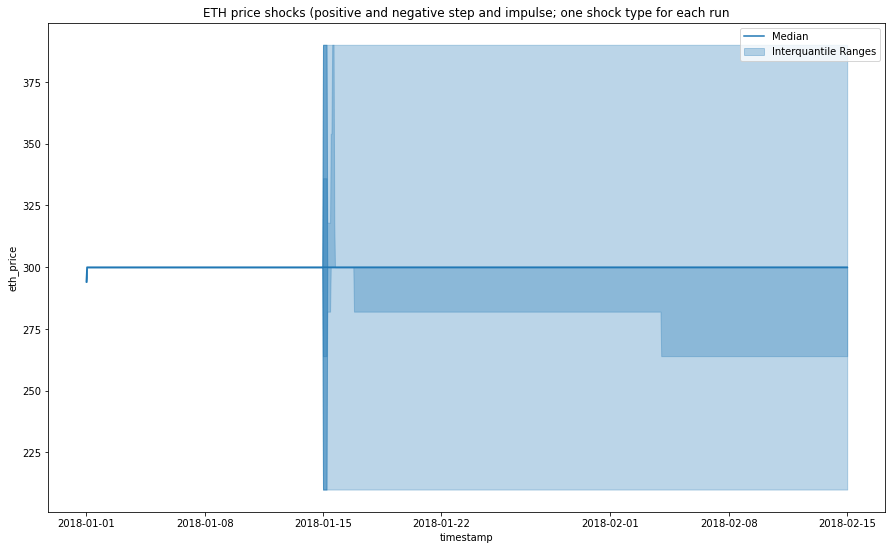

In [37]:
plot_fan_chart(df,'timestamp','timestamp', 'eth_price',lx=False,ly=False,density_hack=False)
plt.title('ETH price shocks (positive and negative step and impulse; one shock type for each run')


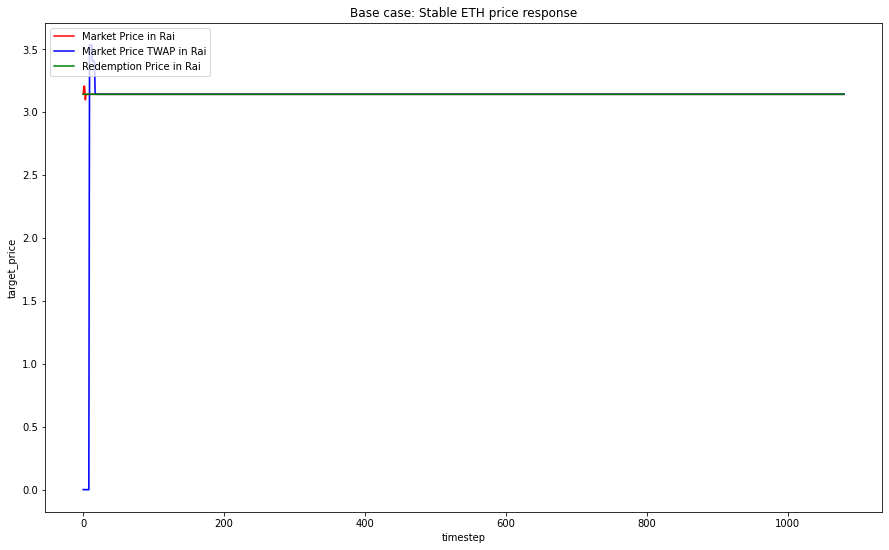

In [43]:
run = df.query('run==1')
plt.figure(figsize=(15,9))
sns.lineplot(data=run,x="timestep", y="market_price",color='r',label='Market Price in Rai')
sns.lineplot(data=run,x="timestep", y="market_price_twap",color='b',label='Market Price TWAP in Rai')
sns.lineplot(data=run,x="timestep", y="target_price",color='g',label='Redemption Price in Rai')
plt.title('Base case: Stable ETH price response')
plt.legend(loc="upper left")

<Figure size 1080x648 with 0 Axes>

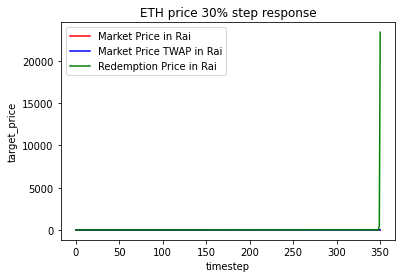

<Figure size 1080x648 with 0 Axes>

In [41]:
run = df.query('run==2').head(500)
sns.lineplot(data=run,x="timestep", y="market_price",color='r',label='Market Price in Rai')
sns.lineplot(data=run,x="timestep", y="market_price_twap",color='b',label='Market Price TWAP in Rai')
sns.lineplot(data=run,x="timestep", y="target_price",color='g',label='Redemption Price in Rai')
plt.title('ETH price 30% step response')
plt.legend(loc="upper left")


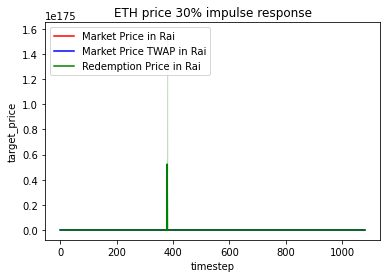

In [21]:
run = df.query('run==3')
sns.lineplot(data=run,x="timestep", y="market_price",color='r',label='Market Price in Rai')
sns.lineplot(data=run,x="timestep", y="market_price_twap",color='b',label='Market Price TWAP in Rai')
sns.lineplot(data=run,x="timestep", y="target_price",color='g',label='Redemption Price in Rai')
plt.title('ETH price 30% impulse response')
plt.legend(loc="upper left")


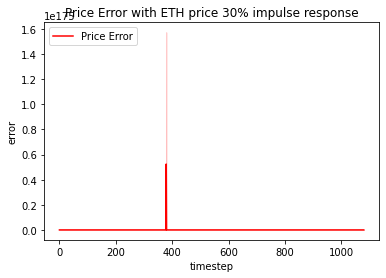

In [22]:
sns.lineplot(data=run,x="timestep", y="error",color='r',label='Price Error')
plt.title('Price Error with ETH price 30% impulse response')
plt.legend(loc="upper left")

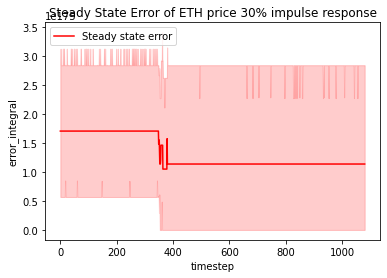

In [23]:
sns.lineplot(data=run,x="timestep", y="error_integral",color='r',label='Steady state error')
plt.title('Steady State Error of ETH price 30% impulse response')
plt.legend(loc="upper left")

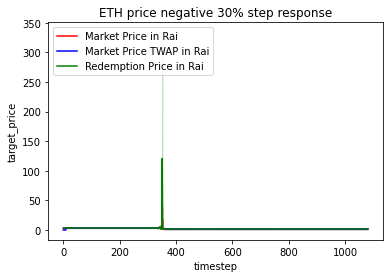

In [24]:
run = df.query('run==4')
sns.lineplot(data=run,x="timestep", y="market_price",color='r',label='Market Price in Rai')
sns.lineplot(data=run,x="timestep", y="market_price_twap",color='b',label='Market Price TWAP in Rai')
sns.lineplot(data=run,x="timestep", y="target_price",color='g',label='Redemption Price in Rai')
plt.title('ETH price negative 30% step response')
plt.legend(loc="upper left")


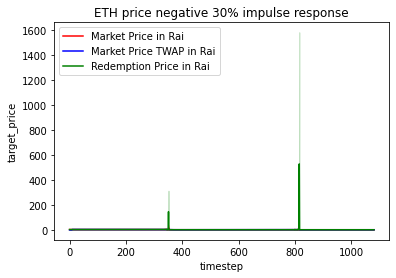

In [25]:
run = df.query('run==5')
sns.lineplot(data=run,x="timestep", y="market_price",color='r',label='Market Price in Rai')
sns.lineplot(data=run,x="timestep", y="market_price_twap",color='b',label='Market Price TWAP in Rai')
sns.lineplot(data=run,x="timestep", y="target_price",color='g',label='Redemption Price in Rai')
plt.title('ETH price negative 30% impulse response')
plt.legend(loc="upper left")

Text(0.5, 1.0, 'Reflexer principal debt')

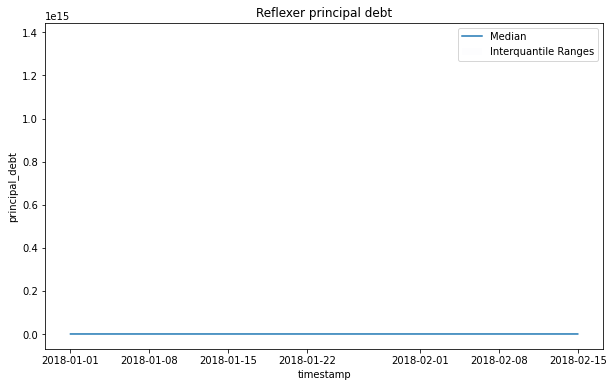

In [26]:
plot_fan_chart(df,'timestamp','timestamp', 'principal_debt',lx=False,ly=False,density_hack=True)
plt.title('Reflexer principal debt')


Text(0.5, 1.0, 'Secondary market RAI balance')

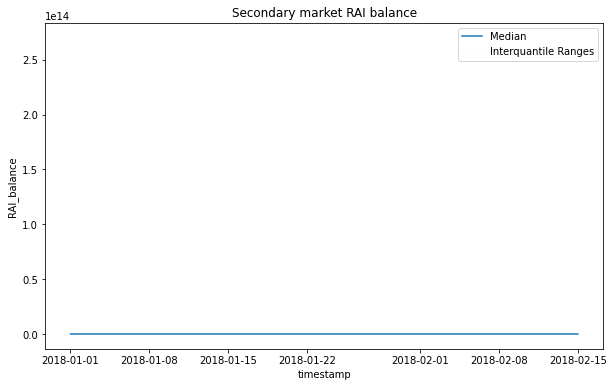

In [27]:
plot_fan_chart(df,'timestamp','timestamp', 'RAI_balance',lx=False,ly=False,density_hack=True)
plt.title('Secondary market RAI balance')


Text(0.5, 1.0, 'Secondary market ETH balance')

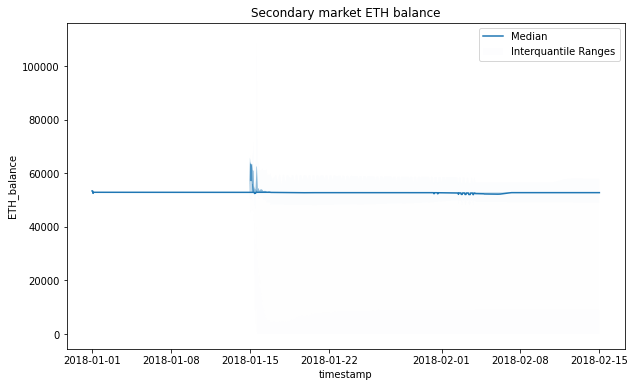

In [28]:
plot_fan_chart(df,'timestamp','timestamp', 'ETH_balance',lx=False,ly=False,density_hack=True)
plt.title('Secondary market ETH balance')


Text(0.5, 1.0, 'Collateralization ratio')

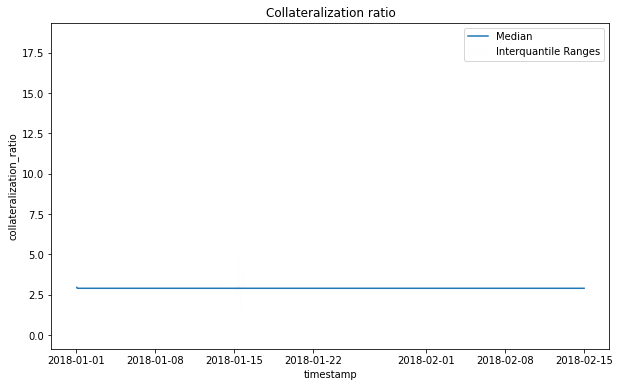

In [29]:
plot_fan_chart(df,'timestamp','timestamp', 'collateralization_ratio',lx=False,ly=False,density_hack=True)
plt.title('Collateralization ratio')


## Conclusion

In this notebook we provided an example of a shock test and the types of plots and analysis that can be performed off of it.